# Step 1 : importing Essential Libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from keras.optimizers import Adam , RMSprop ,SGD ,Adadelta , Adagrad , Adamax  , Nadam

from matplotlib import pyplot
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix


Using TensorFlow backend.


In [2]:
base_skin_dir = os.path.join('..', 'input')
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'}

In [3]:
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))# Creating New Columns for better readability
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((32,32))))
# Checking the image size distribution
skin_df['image'].map(lambda x: x.shape).value_counts()
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']


In [4]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=1234)
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)
# Reshape image in 3 dimensions (height = 128px, width = 128px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(32, 32, 3))
x_test = x_test.reshape(x_test.shape[0], *(32, 32, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(32, 32, 3))


In [5]:
input_shape = (32, 32, 3)
num_classes = 7

filepath="best_model_LeakyReLU.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


In [6]:
model_32 = Sequential()
model_32.add(Conv2D(32, kernel_size=(3, 3),activation="relu",padding = 'Same',input_shape=input_shape))
model_32.add(Conv2D(32,kernel_size=(3, 3), activation="relu",padding = 'Same',))
model_32.add(MaxPool2D(pool_size = (2, 2)))
model_32.add(Dropout(0.25))

model_32.add(Conv2D(64, (3, 3), activation="relu",padding = 'Same'))
model_32.add(Conv2D(64, (3, 3), activation="relu",padding = 'Same'))
model_32.add(MaxPool2D(pool_size=(2, 2)))
model_32.add(Dropout(0.40))

model_32.add(Flatten())
model_32.add(Dense(128, activation="relu"))
model_32.add(Dropout(0.5))
model_32.add(Dense(num_classes, activation='softmax'))

optimizer = Adam()
# Compile the model
model_32.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [7]:
epochs = 100 
batch_size = 64
history_32= model_32.fit(x_train,y_train, batch_size=batch_size,validation_data=(x_test,y_test),
                              epochs = epochs,verbose=0)

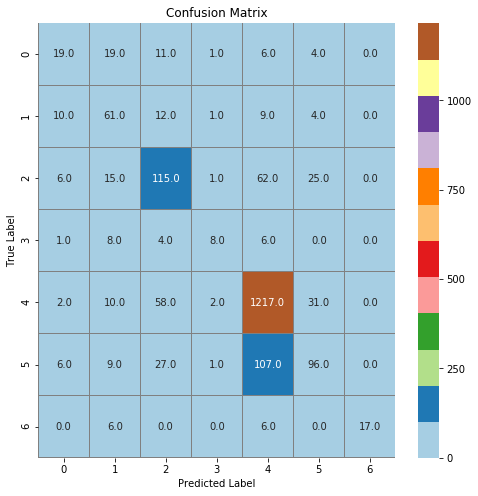

In [8]:
# confusion matrix
import seaborn as sns
# Predict the values from the validation dataset
Y_pred = model_32.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Paired",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [9]:
loss,accuracy=model_32.evaluate(x_test,y_test)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

2003/2003 [==============================] - 0s 69us/step
Test loss: 1.1099395440092577
Test accuracy: 0.7653519723097563


In [10]:
from sklearn.metrics import classification_report
report=classification_report(Y_true, Y_pred_classes)

print(report)

             precision    recall  f1-score   support

          0       0.43      0.32      0.37        60
          1       0.48      0.63      0.54        97
          2       0.51      0.51      0.51       224
          3       0.57      0.30      0.39        27
          4       0.86      0.92      0.89      1320
          5       0.60      0.39      0.47       246
          6       1.00      0.59      0.74        29

avg / total       0.76      0.77      0.76      2003



In [12]:
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))# Creating New Columns for better readability
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((64,64))))
# Checking the image size distribution
skin_df['image'].map(lambda x: x.shape).value_counts()
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']


In [13]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=1234)
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)
# Reshape image in 3 dimensions (height = 128px, width = 128px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(64, 64, 3))
x_test = x_test.reshape(x_test.shape[0], *(64, 64, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(64, 64, 3))

In [14]:
input_shape = (64, 64, 3)
num_classes = 7

filepath="best_model_LeakyReLU.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [15]:
input_shape = (64, 64, 3)
num_classes = 7

filepath="best_model_LeakyReLU.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


model_64 = Sequential()
model_64.add(Conv2D(32, kernel_size=(3, 3),activation="relu",padding = 'Same',input_shape=input_shape))
model_64.add(Conv2D(32,kernel_size=(3, 3), activation="relu",padding = 'Same',))
model_64.add(MaxPool2D(pool_size = (2, 2)))
model_64.add(Dropout(0.25))

model_64.add(Conv2D(64, (3, 3), activation="relu",padding = 'Same'))
model_64.add(Conv2D(64, (3, 3), activation="relu",padding = 'Same'))
model_64.add(MaxPool2D(pool_size=(2, 2)))
model_64.add(Dropout(0.40))

model_64.add(Flatten())
model_64.add(Dense(128, activation="relu"))
model_64.add(Dropout(0.5))
model_64.add(Dense(num_classes, activation='softmax'))

optimizer = Adam()
# Compile the model
model_64.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

epochs = 100 
batch_size = 64
history_64= model_64.fit(x_train,y_train, batch_size=batch_size,validation_data=(x_test,y_test),
                              epochs = epochs,verbose=0)

print("done")

done


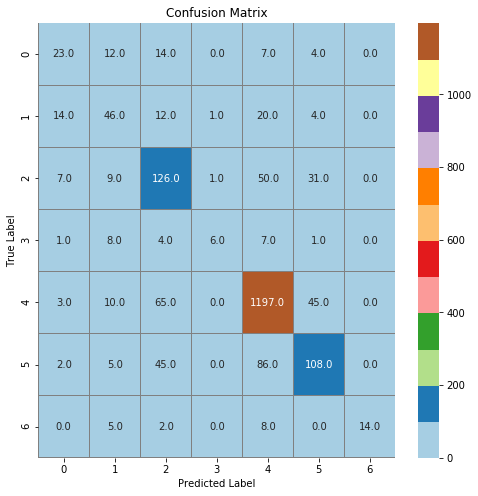

In [16]:
# confusion matrix
import seaborn as sns
# Predict the values from the validation dataset
Y_pred = model_64.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Paired",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [17]:
loss,accuracy=model_64.evaluate(x_test,y_test)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

2003/2003 [==============================] - 0s 130us/step
Test loss: 1.487072475481438
Test accuracy: 0.758861707706661


In [18]:
from sklearn.metrics import classification_report
report=classification_report(Y_true, Y_pred_classes)

print(report)

             precision    recall  f1-score   support

          0       0.46      0.38      0.42        60
          1       0.48      0.47      0.48        97
          2       0.47      0.56      0.51       224
          3       0.75      0.22      0.34        27
          4       0.87      0.91      0.89      1320
          5       0.56      0.44      0.49       246
          6       1.00      0.48      0.65        29

avg / total       0.76      0.76      0.75      2003



In [19]:
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))# Creating New Columns for better readability
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((96,96))))
# Checking the image size distribution
skin_df['image'].map(lambda x: x.shape).value_counts()
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

In [20]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=1234)
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)
# Reshape image in 3 dimensions (height = 128px, width = 128px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(96, 96, 3))
x_test = x_test.reshape(x_test.shape[0], *(96, 96, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(96, 96, 3))

In [21]:
input_shape = (96, 96, 3)
num_classes = 7

filepath="best_model_LeakyReLU.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


model_96 = Sequential()
model_96.add(Conv2D(32, kernel_size=(3, 3),activation="relu",padding = 'Same',input_shape=input_shape))
model_96.add(Conv2D(32,kernel_size=(3, 3), activation="relu",padding = 'Same',))
model_96.add(MaxPool2D(pool_size = (2, 2)))
model_96.add(Dropout(0.25))

model_96.add(Conv2D(64, (3, 3), activation="relu",padding = 'Same'))
model_96.add(Conv2D(64, (3, 3), activation="relu",padding = 'Same'))
model_96.add(MaxPool2D(pool_size=(2, 2)))
model_96.add(Dropout(0.40))

model_96.add(Flatten())
model_96.add(Dense(128, activation="relu"))
model_96.add(Dropout(0.5))
model_96.add(Dense(num_classes, activation='softmax'))

optimizer = Adam()
# Compile the model
model_96.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

epochs = 100 
batch_size = 64
history_96= model_96.fit(x_train,y_train, batch_size=batch_size,validation_data=(x_test,y_test),
                              epochs = epochs,verbose=0)

print("done")

done


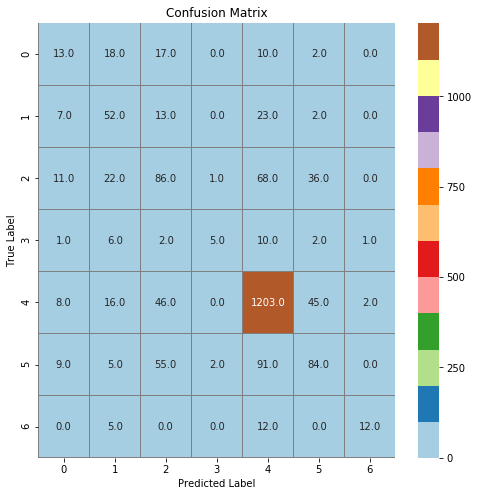

In [22]:
# confusion matrix
import seaborn as sns
# Predict the values from the validation dataset
Y_pred = model_96.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Paired",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [23]:
from sklearn.metrics import classification_report
report=classification_report(Y_true, Y_pred_classes)

print(report)

             precision    recall  f1-score   support

          0       0.27      0.22      0.24        60
          1       0.42      0.54      0.47        97
          2       0.39      0.38      0.39       224
          3       0.62      0.19      0.29        27
          4       0.85      0.91      0.88      1320
          5       0.49      0.34      0.40       246
          6       0.80      0.41      0.55        29

avg / total       0.71      0.73      0.71      2003



In [24]:
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))# Creating New Columns for better readability
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((128,128))))
# Checking the image size distribution
skin_df['image'].map(lambda x: x.shape).value_counts()
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

In [25]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.25,random_state=1234)
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.25, random_state = 2)
# Reshape image in 3 dimensions (height = 128px, width = 128px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(128, 128, 3))
x_test = x_test.reshape(x_test.shape[0], *(128, 128, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(128, 128, 3))

In [26]:
input_shape = (128, 128, 3)
num_classes = 7

filepath="best_model_LeakyReLU.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [27]:
model_128= Sequential()
model_128.add(Conv2D(32, kernel_size=(3, 3),activation="relu",padding = 'Same',input_shape=input_shape))
model_128.add(Conv2D(32,kernel_size=(3, 3), activation="relu",padding = 'Same',))
model_128.add(MaxPool2D(pool_size = (2, 2)))
model_128.add(Dropout(0.25))

model_128.add(Conv2D(64, (3, 3), activation="relu",padding = 'Same'))
model_128.add(Conv2D(64, (3, 3), activation="relu",padding = 'Same'))
model_128.add(MaxPool2D(pool_size=(2, 2)))
model_128.add(Dropout(0.40))

model_128.add(Flatten())
model_128.add(Dense(128, activation="relu"))
model_128.add(Dropout(0.5))
model_128.add(Dense(num_classes, activation='softmax'))

optimizer = Adam()
# Compile the model
model_128.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

epochs = 100 
batch_size = 64
history_128= model_128.fit(x_train,y_train, batch_size=batch_size,validation_data=(x_test,y_test),
                              epochs = epochs,verbose=0)

print("done")

done


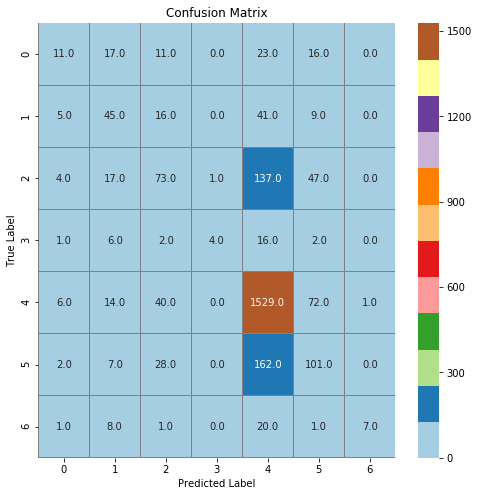

In [29]:
# confusion matrix
import seaborn as sns
# Predict the values from the validation dataset
Y_pred = model_128.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Paired",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [31]:
loss,accuracy=model_128.evaluate(x_test,y_test)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

2504/2504 [==============================] - 1s 377us/step
Test loss: 2.2395440708673275
Test accuracy: 0.7068690095846646


In [32]:
from sklearn.metrics import classification_report
report=classification_report(Y_true, Y_pred_classes)

print(report)

             precision    recall  f1-score   support

          0       0.37      0.14      0.20        78
          1       0.39      0.39      0.39       116
          2       0.43      0.26      0.32       279
          3       0.80      0.13      0.22        31
          4       0.79      0.92      0.85      1662
          5       0.41      0.34      0.37       300
          6       0.88      0.18      0.30        38

avg / total       0.68      0.71      0.68      2504



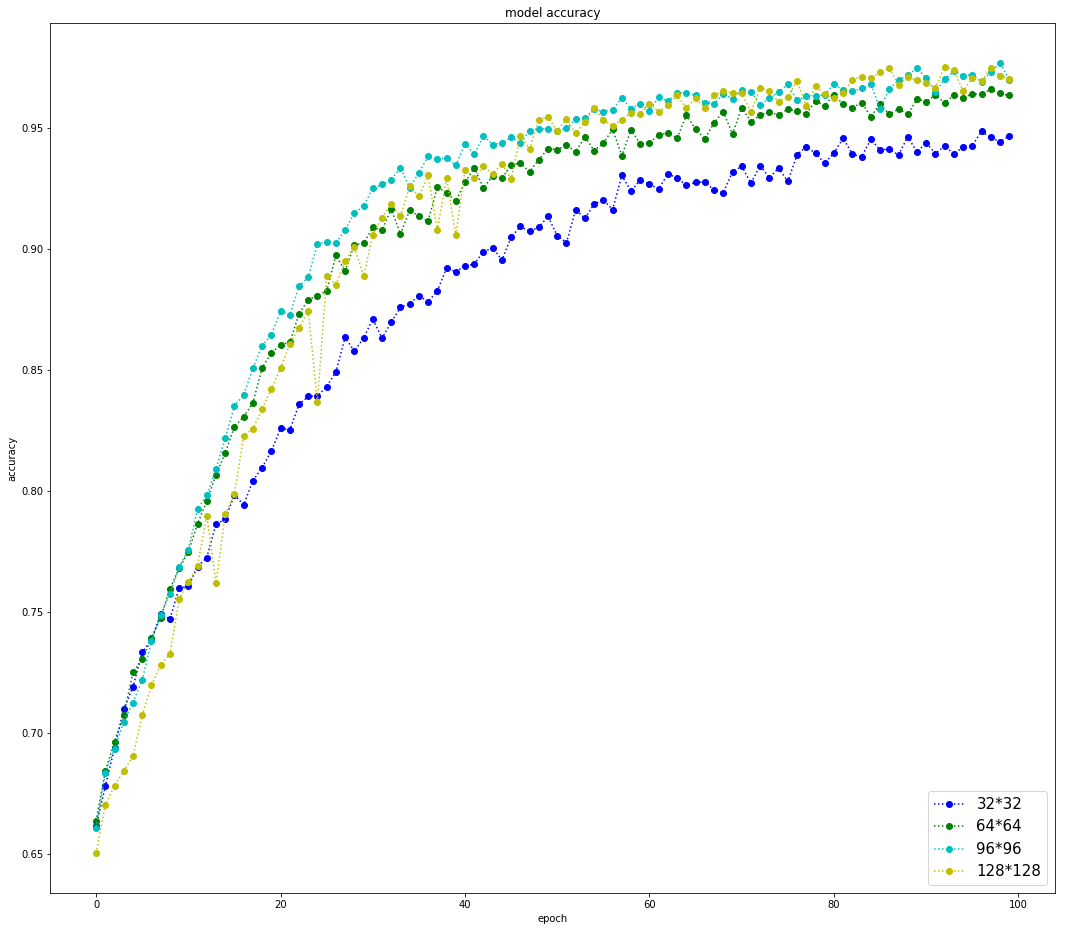

In [33]:

# summarize history for accuracy
plt.rcParams["figure.figsize"] = (18,16)
plt.plot(history_32.history['acc'] ,'o:b')
plt.plot(history_64.history['acc'] ,'o:g')
plt.plot(history_96.history['acc'] ,'o:c')
plt.plot(history_128.history['acc'] ,'o:y')


#********************************************************
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['32*32',"64*64","96*96","128*128"], loc='lower right',prop={'size': 15})
plt.show()

In [ ]:
# from sklearn import metrics
# import re
# from io import StringIO



# def report_to_df(report):
#     report = re.sub(r" +", " ", report).replace("avg / total", "avg/total").replace("\n ", "\n")
#     report_df = pd.read_csv(StringIO("Classes" + report), sep=' ', index_col=0)        
#     return(report_df)

# #txt report to df
# report = metrics.classification_report(Y_true, Y_pred_classes)
# report_df3 = report_to_df(report)

# #store, print, copy...
# print (report_df)

In [ ]:
# data.to_excel(r'asd.xlsx', index=False)
# from IPython.display import FileLink
# FileLink(r'asd.xlsx')